In [1]:
import mne
import numpy as np
from pathlib import Path
import time

from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from ica_benchmark.scoring import SCORING_FN_DICT, apply_pairwise_parallel
from ica_benchmark.processing.ica import get_all_methods, get_ica_instance
from ica_benchmark.processing.orica_code import ORICA

from ica_benchmark.io.load import BCI_IV_Comp_Dataset
from sklearn.cross_decomposition import PLSCanonical

from sacred.observers import MongoObserver, FileStorageObserver
from sacred import Experiment

import json

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV

from mne.decoding import CSP
from mne.time_frequency import psd_multitaper, psd_welch, psd_array_welch

def cue_name(cue):
    return {
        0: "Left hand",
        1: "Right hand",
        2: "Foot",
        3: "Tongue",
    }[cue]

class ConcatenateChannelsPSD(BaseEstimator):
    def __init__(self):
        super(ConcatenateChannelsPSD).__init__()

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        n = len(x)
        return x.reshape(n, -1)


class PSD(BaseEstimator):
    BANDS_DICT = {
#         "delta": (1, 4),
#         "theta": (4, 8),
#         "mu": (8, 13),
        "mu": (8, 13),
#         "beta": (13, 25),
        "beta": (13, 25),
#         "gamma": (25, 40)
    }
    def __init__(self, **kwargs):
        super(PSD).__init__()
        self.kwargs = kwargs
        
    def set_params(**params):
        for param in params:
            assert params in ["picks", "n_fft", "n_overlap", "n_per_seg"]
        self.kwargs.update(params)
    
    def get_params(self, *args, **kwargs):
        return self.kwargs
        
    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        if isinstance(x, list):
            x = mne.concatenate_epochs(x)
            psds, freqs = psd_welch(x, ** self.kwargs)
        if isinstance(x, mne.Epochs):
            psds, freqs = psd_welch(x, ** self.kwargs)
        if isinstance(x, np.ndarray):
            psds, freqs = psd_array_welch(x, ** self.kwargs)
        if ("average" in self.kwargs) and (self.kwargs["average"] is None):
            psds = psds.sum(axis=3)
        self.freqs = freqs

        band_spectras = list()
        for band, (lfreq, hfreq) in self.BANDS_DICT.items():
            band_spectra = psds[:, :, (freqs >= lfreq) & (freqs < hfreq)]
            band_spectras.append(
                band_spectra.sum(axis=2, keepdims=True)
            )
        
        band_spectras = np.concatenate(band_spectras, axis=2)
            
        return band_spectras

def whitening(x, mean=None, std=None):
    is_epochs = isinstance(x, mne.Epochs)
    if is_epochs:
        epochs = x.copy()
        x = x._data
        is_epochs = True
        
    n_epochs, n_channels, n_times = x.shape
    
    x = x.transpose(1, 0, 2).reshape(n_channels, -1)
    if mean is None:
        mean = x.mean(axis=1, keepdims=True)
    
    if std is None:
        std = x.std(axis=1, keepdims=True)
        
    x -= mean
    x /= std
    
    x = x.reshape(n_channels, n_epochs, n_times).transpose(1, 0, 2)
    
    if is_epochs:
        epochs._data = x
        return epochs, mean, std
    
    return x, mean, std
    
root = Path("/home/paulo/Documents/datasets/BCI_Comp_IV_2a/gdf/")
selected_channels = ["EEG-Fz", "EEG-C3", "EEG-C4", "EEG-Cz"]
filepaths = sorted(root.glob("A*T.gdf"))

# clf.predict(full_epochs)

In [2]:
import functools

TEST_LABEL_FOLDER = Path("/home/paulo/Documents/datasets/BCI_Comp_IV_2a/true_labels/")
DEFAULT_TIME_BANDS = [(3, 6)]
def preprocess_epochs(epochs, timebands=None, car_filter=True):
    if timebands is None:
        timebands = DEFAULT_TIME_BANDS
    epochs = epochs.copy()
    
    epochs.load_data()
#     epochs.filter(5, 60)
    
    if car_filter:
        epochs.set_eeg_reference("average")
    events = epochs.events[:, 2]
#     epochs.drop(~((events == 0) | (events == 1)))

    partial_epochs = list()
#     for timeband in [(3, 5), (4, 6)]:
#     for timeband in [(0, 2), (1, 3), (3, 5), (4, 6)]:
#     for timeband in [(3, 4), (4, 5), (5, 6)]:
#     for timeband in [(3, 6)]:
#         partial_epochs.append(
#             epochs.copy().crop(*timeband).shift_time(-timeband[0])
#         )
#     epochs = mne.concatenate_epochs(partial_epochs).copy()
    return epochs

def load_subject_epochs(subject_number, test_label_folder=TEST_LABEL_FOLDER):
    train_file_path = root / "A{}T.gdf".format(str(subject_number).rjust(2, "0"))
    test_file_path = root / "A{}E.gdf".format(str(subject_number).rjust(2, "0"))
    test_label_file_path = test_label_folder / "A{}E.csv".format(str(subject_number).rjust(2, "0"))
    train_epochs = BCI_IV_Comp_Dataset.load_dataset(
        [train_file_path],
        reject=False,
        as_epochs=True,
        concatenate=False,
        drop_bad=False,
        return_metadata=False,
        tmin=0.,
        tmax=4.,
    )[0]
    test_epochs = BCI_IV_Comp_Dataset.load_dataset(
        [test_file_path],
        reject=False,
        as_epochs=True,
        concatenate=False,
        drop_bad=False,
        return_metadata=False,
        tmin=0.,
        # The last timestamp does not exist, so MNE will ignore the last epoch because it will not end in 6s
        # So here we use 5.5 seconds because there will always be 5.5 seconds after a event
        tmax=4.,
        has_labels=False
    )[0]

    train_epochs = preprocess_epochs(train_epochs, car_filter=False)
    test_epochs = preprocess_epochs(test_epochs, car_filter=False)
    
#     train_epochs.drop_bad(dict(eeg=1e-4))

    train_events = train_epochs.events[:, 2].flatten()
    train_epochs.drop(~((train_events == 0) | (train_events == 1)))
    train_labels = train_epochs.events[:, 2]
    
    test_labels = pd.read_csv(test_label_file_path, header=None).to_numpy().flatten() - 1
    assert len(test_labels) == len(test_epochs), "{} epochs | {} labels".format(len(test_epochs), len(test_labels))
    
    test_epochs.events[:, 2] = test_labels
    test_epochs.drop(~((test_labels == 0) | (test_labels == 1)))
    test_labels = test_epochs.events[:, 2]

    return (train_epochs, train_labels), (test_epochs, test_labels)



In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SequentialFeatureSelector


def get_corr_features(x):
    features = list()
    for i in range(len(x)):
        corr_matrix = np.corrcoef(x[i])
        idx1, idx2 = np.triu_indices(corr_matrix.shape[0], 1)
        features.append(
            corr_matrix[idx1, idx2].reshape(1, -1)
        )
    return np.vstack(features)


class CSPWrapper(BaseEstimator):
    def __init__(self, n_components=4):
        self.n_components = n_components
        self.csp = None

    def fit(self, x, y):
        self.csp = CSP(n_components=self.n_components)
        self.csp.fit(x, y)
        return self
    
    def transform(self, x):
        return self.csp.transform(x)
    
    def set_params(self, **params):
        self.n_components = params["n_components"]
        self.csp = CSP(n_components=self.n_components)
        return self
    
    def get_params(self, deep=True):
        return dict(n_components=self.n_components)
    
def run(filepath, ica_methods=None, channels=None, random_state=1):
    ica_methods = [None] if ica_methods is None else ica_methods
    methods_dict = dict()

    subject_number = int(filepath.name[1:3])
    (train_epochs, train_labels), (test_epochs, test_labels) = load_subject_epochs(subject_number)
        
    selected_channels = channels
    if channels is None:
        selected_channels = train_epochs.ch_names

    train_epochs.pick(selected_channels)
    test_epochs.pick(selected_channels)

    for ica_method in ica_methods:
        print(ica_method)
        scores_dict = dict()


        
        x_train, y_train = train_epochs.copy(), train_labels
        x_test, y_test = test_epochs.copy(), test_labels
        
        len_size = 250
        
#         if ica_method in ["fastica", "sobi", "jade"]:
        if ica_method in ["sobi", "jade"]:
            x_train, train_mean, train_std = whitening(x_train)
            x_test, _, _ = whitening(x_test, mean=train_mean, std=train_std)

        if (ica_method == "orica") or (ica_method is None):
            x_train = x_train.get_data()
            x_test = x_test.get_data()
            
            ICA = ORICA(
                mode="decay",
                n_channels=len(selected_channels),
                block_update=True,
                size_block=8,
                stride=8,
                lm_0=.995,
                lw_0=.995,
                gamma=.6,
                n_sub=0,
            )
            ICA.fit(x_train)

            n_epochs, n_channels, n_times = x_train.shape
            x = x_train.transpose(1, 0, 2).reshape(n_channels, -1)
            x_train = (
                ICA
                .transform(
                    x,
                    scaling=1e6,
                    save=False,
                )
                .reshape(n_channels, n_epochs, n_times)
                .transpose(1, 0, 2)
            )

            #################################################################################
            ICA.mode = "constant"
            last_iter = ICA.iteration[-1]
            div = last_iter ** ICA.gamma            
            ICA.lm_0, ICA.lw_0 = 0.001, 0.001
            #################################################################################
            
            n_epochs, n_channels, n_times = x_test.shape
            x = x_test.transpose(1, 0, 2).reshape(n_channels, -1)
            x_test = (
                ICA
                .transform(
                    x,
                    scaling=1e6,
                    save=False,
                    warm_start=True
                )
                .reshape(n_channels, n_epochs, n_times)
                .transpose(1, 0, 2)
            )
            psd = PSD(
                sfreq=train_epochs.info["sfreq"],
                n_fft=1 * len_size,
                n_overlap=len_size // 4,
                n_per_seg=1 * len_size,
                average="mean",
                window="hamming",
            )
        else:
            ICA = get_ica_instance(ica_method, random_state=random_state)
            ica_channels = ["ICA{}".format(str(i).rjust(3, "0")) for i in range(len(selected_channels))]    

            ICA.fit(x_train)
            x_train = ICA.transform(x_train)
            x_test = ICA.transform(x_test)
            psd = PSD(
                picks=x_train.ch_names,
                n_fft=1 * len_size,
                n_overlap=len_size // 4,
                n_per_seg=1 * len_size,
                average="mean",
                window="hamming",
                proj=False
            )

            
        classifier = LDA(n_components=1)
        SFS = SequentialFeatureSelector(
            LDA(n_components=1),
            direction='forward',
            cv=4,
            scoring=make_scorer(cohen_kappa_score, greater_is_better=True)
        )
        param_grid = dict(
#             svc__C=np.logspace(-2, 2, 10),
#             svc__C=[.01, .1, 1, 10],
#             selectkbest__k=[10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, ]
#             lineardiscriminantanalysis__n_components=[1, 2, 4],
#             csp__n_components=[1, 2, 3, 4, 5]
            sequentialfeatureselector__n_features_to_select=[1, 2, 3, 5, 10, 15, 20, 30],
#             plscanonical__n_components=[1, 2, 3, 4, 5]
        )

        psd.fit(x_train)
        x_train = psd.transform(x_train)
        x_test = psd.transform(x_test)

        # 2 classes
        clf = make_pipeline(
            ConcatenateChannelsPSD(),
            StandardScaler(),
            SFS,
            classifier
        )

        gs_cv = GridSearchCV(
            clf,
            param_grid=param_grid,
            cv=4,
            scoring=make_scorer(cohen_kappa_score, greater_is_better=True),
            error_score=-1,
            refit=True,
            n_jobs=3,
            verbose=0
        )
        print("Fitting... ", end="")
        start = time.time()
        gs_cv.fit(x_train, y_train)
        end = time.time()
        print("Done (took {:.2f}s)".format(end - start))

        pred  = gs_cv.predict(x_test)
        bas = balanced_accuracy_score(y_test, pred)
        acc = accuracy_score(y_test, pred)
        kappa = cohen_kappa_score(y_test, pred)

        scores_dict["kappa"] = kappa
        scores_dict["acc"] = acc
        scores_dict["bas"] = bas
        scores_dict["time"] = end - start
        
        scores_dict["best_params"] = gs_cv.best_params_
        methods_dict[ica_method] = scores_dict
        
        print("Kappa", kappa)
        print("Accuracy", acc)
        print("BAS", bas)
        
    return methods_dict
        


In [4]:
ica_methods = set(list(get_all_methods()) + ["orica"])
# ica_methods = ["orica"]
exclude_methods = [
    "choi_var",
    "choi_vartd",
    "choi_td",
    "coro"
]
ica_methods.difference_update(exclude_methods)

results = dict()
for filepath in filepaths:
    print(filepath.name)
    subject_results_dict = run(filepath, ica_methods=ica_methods)
    results[filepath.name] = subject_results_dict

A01T.gdf
fastica
Fitting... Done (took 62.23s)
Kappa 0.5555555555555556
Accuracy 0.7777777777777778
BAS 0.7777777777777777
sobi
Fitting... Done (took 51.23s)
Kappa 0.4027777777777778
Accuracy 0.7013888888888888
BAS 0.7013888888888888
ext_picard
Fitting... Done (took 48.77s)
Kappa 0.6111111111111112
Accuracy 0.8055555555555556
BAS 0.8055555555555556
orica


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Fitting... Done (took 54.62s)
Kappa 0.5277777777777778
Accuracy 0.7638888888888888
BAS 0.7638888888888888
ext_infomax
Fitting... Done (took 47.26s)
Kappa 0.5694444444444444
Accuracy 0.7847222222222222
BAS 0.7847222222222222
jade
Fitting... Done (took 52.57s)
Kappa 0.4722222222222222
Accuracy 0.7361111111111112
BAS 0.7361111111111112
infomax
Fitting... Done (took 50.63s)
Kappa 0.4305555555555556
Accuracy 0.7152777777777778
BAS 0.7152777777777778
picard
Fitting... Done (took 47.01s)
Kappa 0.6111111111111112
Accuracy 0.8055555555555556
BAS 0.8055555555555556
A02T.gdf
fastica
Fitting... Done (took 53.30s)
Kappa 0.04166666666666663
Accuracy 0.5208333333333334
BAS 0.5208333333333334
sobi
Fitting... Done (took 46.47s)
Kappa -0.01388888888888884
Accuracy 0.4930555555555556
BAS 0.4930555555555556
ext_picard
Fitting... Done (took 45.79s)
Kappa 0.11111111111111116
Accuracy 0.5555555555555556
BAS 0.5555555555555556
orica


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Fitting... Done (took 47.28s)
Kappa 0.11111111111111116
Accuracy 0.5555555555555556
BAS 0.5555555555555556
ext_infomax
Fitting... Done (took 47.90s)
Kappa 0.13888888888888884
Accuracy 0.5694444444444444
BAS 0.5694444444444444
jade
Fitting... Done (took 52.23s)
Kappa 0.02777777777777779
Accuracy 0.5138888888888888
BAS 0.5138888888888888
infomax
Fitting... Done (took 52.98s)
Kappa 0.26388888888888884
Accuracy 0.6319444444444444
BAS 0.6319444444444444
picard
Fitting... Done (took 46.94s)
Kappa 0.11111111111111116
Accuracy 0.5555555555555556
BAS 0.5555555555555556
A03T.gdf
fastica
Fitting... Done (took 46.34s)
Kappa 0.9166666666666666
Accuracy 0.9583333333333334
BAS 0.9583333333333334
sobi
Fitting... Done (took 46.33s)
Kappa 0.8055555555555556
Accuracy 0.9027777777777778
BAS 0.9027777777777777
ext_picard
Fitting... Done (took 49.93s)
Kappa 0.6666666666666667
Accuracy 0.8333333333333334
BAS 0.8333333333333334
orica


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Fitting... Done (took 46.41s)
Kappa 0.6111111111111112
Accuracy 0.8055555555555556
BAS 0.8055555555555556
ext_infomax
Fitting... Done (took 51.47s)
Kappa 0.7638888888888888
Accuracy 0.8819444444444444
BAS 0.8819444444444444
jade
Fitting... Done (took 47.41s)
Kappa 0.6805555555555556
Accuracy 0.8402777777777778
BAS 0.8402777777777778
infomax
Fitting... Done (took 50.34s)
Kappa 0.875
Accuracy 0.9375
BAS 0.9375
picard
Fitting... Done (took 50.42s)
Kappa 0.6666666666666667
Accuracy 0.8333333333333334
BAS 0.8333333333333334
A04T.gdf
fastica
Fitting... Done (took 51.29s)
Kappa 0.3194444444444444
Accuracy 0.6597222222222222
BAS 0.6597222222222223
sobi
Fitting... Done (took 51.71s)
Kappa 0.4027777777777778
Accuracy 0.7013888888888888
BAS 0.7013888888888888
ext_picard
Fitting... Done (took 53.63s)
Kappa 0.3055555555555556
Accuracy 0.6527777777777778
BAS 0.6527777777777778
orica


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Fitting... Done (took 45.62s)
Kappa 0.2777777777777778
Accuracy 0.6388888888888888
BAS 0.6388888888888888
ext_infomax
Fitting... Done (took 53.96s)
Kappa 0.36111111111111116
Accuracy 0.6805555555555556
BAS 0.6805555555555556
jade
Fitting... Done (took 50.36s)
Kappa 0.20833333333333337
Accuracy 0.6041666666666666
BAS 0.6041666666666667
infomax
Fitting... Done (took 51.44s)
Kappa 0.26388888888888884
Accuracy 0.6319444444444444
BAS 0.6319444444444444
picard
Fitting... Done (took 53.46s)
Kappa 0.3055555555555556
Accuracy 0.6527777777777778
BAS 0.6527777777777778
A05T.gdf
fastica
Fitting... Done (took 51.89s)
Kappa 0.05555555555555558
Accuracy 0.5277777777777778
BAS 0.5277777777777778
sobi
Fitting... Done (took 47.91s)
Kappa -0.08333333333333326
Accuracy 0.4583333333333333
BAS 0.4583333333333333
ext_picard
Fitting... Done (took 50.32s)
Kappa 0.01388888888888884
Accuracy 0.5069444444444444
BAS 0.5069444444444444
orica


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Fitting... Done (took 50.10s)
Kappa 0.23611111111111116
Accuracy 0.6180555555555556
BAS 0.6180555555555556
ext_infomax
Fitting... Done (took 48.53s)
Kappa -0.01388888888888884
Accuracy 0.4930555555555556
BAS 0.4930555555555555
jade
Fitting... Done (took 47.73s)
Kappa 0.04166666666666663
Accuracy 0.5208333333333334
BAS 0.5208333333333334
infomax
Fitting... Done (took 45.77s)
Kappa 0.09722222222222221
Accuracy 0.5486111111111112
BAS 0.5486111111111112
picard
Fitting... Done (took 52.72s)
Kappa 0.01388888888888884
Accuracy 0.5069444444444444
BAS 0.5069444444444444
A06T.gdf
fastica
Fitting... Done (took 52.95s)
Kappa 0.20833333333333337
Accuracy 0.6041666666666666
BAS 0.6041666666666666
sobi
Fitting... Done (took 46.58s)
Kappa 0.18055555555555558
Accuracy 0.5902777777777778
BAS 0.5902777777777778
ext_picard
Fitting... Done (took 52.75s)
Kappa 0.18055555555555558
Accuracy 0.5902777777777778
BAS 0.5902777777777778
orica


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Fitting... Done (took 46.31s)
Kappa 0.19444444444444442
Accuracy 0.5972222222222222
BAS 0.5972222222222222
ext_infomax
Fitting... Done (took 52.46s)
Kappa 0.2777777777777778
Accuracy 0.6388888888888888
BAS 0.6388888888888888
jade
Fitting... Done (took 49.08s)
Kappa 0.1527777777777778
Accuracy 0.5763888888888888
BAS 0.5763888888888888
infomax
Fitting... Done (took 49.78s)
Kappa 0.16666666666666663
Accuracy 0.5833333333333334
BAS 0.5833333333333333
picard
Fitting... Done (took 51.67s)
Kappa 0.18055555555555558
Accuracy 0.5902777777777778
BAS 0.5902777777777778
A07T.gdf
fastica
Fitting... Done (took 49.25s)
Kappa 0.48611111111111116
Accuracy 0.7430555555555556
BAS 0.7430555555555556
sobi
Fitting... Done (took 45.57s)
Kappa 0.26388888888888884
Accuracy 0.6319444444444444
BAS 0.6319444444444444
ext_picard
Fitting... Done (took 46.28s)
Kappa 0.4305555555555556
Accuracy 0.7152777777777778
BAS 0.7152777777777778
orica


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Fitting... Done (took 51.21s)
Kappa 0.6388888888888888
Accuracy 0.8194444444444444
BAS 0.8194444444444444
ext_infomax
Fitting... Done (took 46.17s)
Kappa 0.48611111111111116
Accuracy 0.7430555555555556
BAS 0.7430555555555556
jade
Fitting... Done (took 47.26s)
Kappa 0.125
Accuracy 0.5625
BAS 0.5625
infomax
Fitting... Done (took 45.81s)
Kappa 0.4027777777777778
Accuracy 0.7013888888888888
BAS 0.7013888888888888
picard
Fitting... Done (took 47.45s)
Kappa 0.4305555555555556
Accuracy 0.7152777777777778
BAS 0.7152777777777778
A08T.gdf
fastica
Fitting... Done (took 45.60s)
Kappa 0.8472222222222222
Accuracy 0.9236111111111112
BAS 0.9236111111111112
sobi
Fitting... Done (took 48.73s)
Kappa 0.5
Accuracy 0.75
BAS 0.75
ext_picard
Fitting... Done (took 46.45s)
Kappa 0.875
Accuracy 0.9375
BAS 0.9375
orica


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Fitting... Done (took 48.88s)
Kappa 0.9027777777777778
Accuracy 0.9513888888888888
BAS 0.9513888888888888
ext_infomax
Fitting... Done (took 45.98s)
Kappa 0.8472222222222222
Accuracy 0.9236111111111112
BAS 0.9236111111111112
jade
Fitting... Done (took 53.61s)
Kappa 0.2777777777777778
Accuracy 0.6388888888888888
BAS 0.6388888888888888
infomax
Fitting... Done (took 46.06s)
Kappa 0.8611111111111112
Accuracy 0.9305555555555556
BAS 0.9305555555555556
picard
Fitting... Done (took 46.26s)
Kappa 0.875
Accuracy 0.9375
BAS 0.9375
A09T.gdf
fastica
Fitting... Done (took 49.62s)
Kappa 0.7638888888888888
Accuracy 0.8819444444444444
BAS 0.8819444444444444
sobi
Fitting... Done (took 47.77s)
Kappa 0.6944444444444444
Accuracy 0.8472222222222222
BAS 0.8472222222222222
ext_picard
Fitting... Done (took 51.55s)
Kappa 0.7083333333333333
Accuracy 0.8541666666666666
BAS 0.8541666666666667
orica


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Fitting... Done (took 47.15s)
Kappa 0.6527777777777778
Accuracy 0.8263888888888888
BAS 0.8263888888888888
ext_infomax
Fitting... Done (took 48.31s)
Kappa 0.75
Accuracy 0.875
BAS 0.875
jade
Fitting... Done (took 47.64s)
Kappa 0.38888888888888884
Accuracy 0.6944444444444444
BAS 0.6944444444444444
infomax
Fitting... Done (took 46.47s)
Kappa 0.7777777777777778
Accuracy 0.8888888888888888
BAS 0.8888888888888888
picard
Fitting... Done (took 51.68s)
Kappa 0.7083333333333333
Accuracy 0.8541666666666666
BAS 0.8541666666666667


In [8]:
kappa_dict = dict()
for uid, r in results.items():
    for alg, alg_r in r.items():
        if not alg in kappa_dict:
            kappa_dict[alg] = list()
        kappa_dict[alg].append(alg_r["kappa"])

for alg, alg_r in kappa_dict.items():
    print(
        "{}: AVG: {:.3f}, STD: {:.2f}".format(
            alg,
            np.mean(alg_r),
            np.std(alg_r),
        )
    )

fastica: AVG: 0.466, STD: 0.31
sobi: AVG: 0.350, STD: 0.28
ext_picard: AVG: 0.434, STD: 0.28
orica: AVG: 0.461, STD: 0.25
ext_infomax: AVG: 0.465, STD: 0.28
jade: AVG: 0.264, STD: 0.20
infomax: AVG: 0.460, STD: 0.29
picard: AVG: 0.434, STD: 0.28


In [29]:
kappa_dict = dict()
for uid, r in results.items():
    for alg, alg_r in r.items():
        if not alg in kappa_dict:
            kappa_dict[alg] = list()
        kappa_dict[alg].append(alg_r["kappa"])

for alg, alg_r in kappa_dict.items():
    print(alg, np.mean(alg_r))

orica 0.46141975308641975


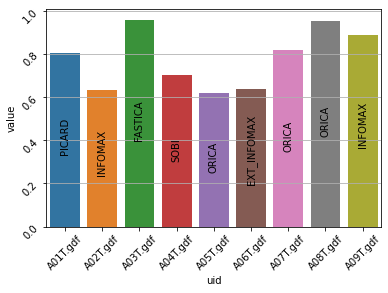

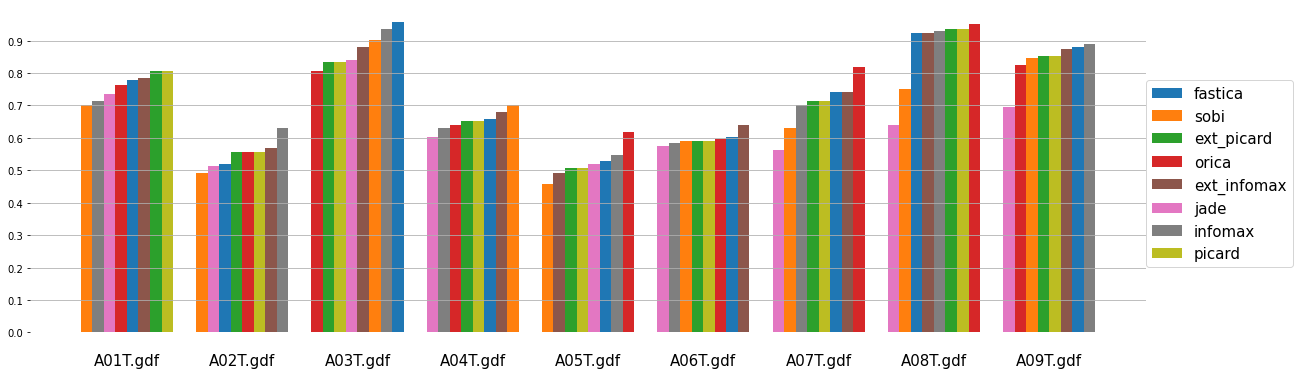

In [115]:
from matplotlib.colors import Colormap
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def flatten_results(results_dict):
    lines = list()
    columns = ["uid", "algorithm", "metric", "value"]
    for uid, alg_metrics in results_dict.items():
        for alg_name, metrics in alg_metrics.items():
            for metric_name, value in metrics.items():
                lines.append(
                    [uid, alg_name, metric_name, value]
                )
    results_df = pd.DataFrame(lines, columns=columns)
    return  results_df


def plot_sub_barplot(results_df, metric="kappa", algorithms=None, figsize=None):
    
    if figsize is None:
        figsize = (12, 5)
    if algorithms is None:
        algorithms = results_df.algorithm.unique()
    
    df = results_df.query("(metric == @metric) & (algorithm in @algorithms)")
    
    
    plt.figure(figsize=figsize)
    plt.grid()
    sns.barplot(x="uid", y="value", data=df, hue="algorithm", ax=plt.gca())
    plt.show()
    

def plot_best_algorithm(results_df, metric="kappa", algorithms=None, figsize=None):
    if algorithms is None:
        algorithms = results_df.algorithm.unique()
    
    df = results_df.query("(metric == @metric) & (algorithm in @algorithms)")
    return df.groupby("uid").max()


def single(ax, labels):
    for p, label in zip(ax.patches, labels):
        _x = p.get_x() + p.get_width() / 2
        _y = (p.get_y() + p.get_height() - len(label)/ 50) / 2
        ax.text(_x, _y, label.upper(), ha="center", rotation=90) 

def plot_best_algorithm(results_df, metric="kappa", algorithms=None, figsize=None):
    if algorithms is None:
        algorithms = results_df.algorithm.unique()
    
    df = results_df.query("(metric == @metric) & (algorithm in @algorithms)")
    df = df.sort_values(by="value", ascending=False).drop_duplicates(subset="uid").sort_values(by="uid")
    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.grid()
    sns.barplot(x="uid", y="value", data=df, label="algorithm", ax=ax)
    single(ax, df.algorithm.to_numpy())
    ax.tick_params(labelrotation=45)
    plt.show()

def sortedgroupedbar(results_df, metric="kappa"):
    w = 5
    plt.figure(figsize=(20, 6))
    ax = plt.gca()
    cmap = plt.get_cmap("tab10")
    algs = results_df.algorithm.unique()
    n_algs = len(algs)
    algorithm_color_dict = {
        alg: cmap(i / n_algs)
        for i, alg
        in enumerate(algs)
    }
    
    x_c = w / 2
    legends = [
         Patch(
             facecolor=algorithm_color_dict[alg],
             edgecolor=None,
             label=alg
         )
        for alg in algs
    ]
    for uid in results_df.uid.unique():
        df = results_df.query("(uid == @uid) & (metric == @metric)").sort_values(by="value").reset_index(drop=True)
        
        x_list = list()
        for i, r in df.iterrows():
            x_list.append(x_c)
            ax.bar(x_c, r.value, width=w, color=algorithm_color_dict[r.algorithm])
            x_c += w
        x_c += w * 2
        
        mid = np.mean(x_list)
        ax.text(mid, -0.1, uid, horizontalalignment="center", fontsize=15)
        
#         ax.set_xticks()
        
    for loc in ["right", "left", "top", "bottom"]:
        ax.spines[loc].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks(np.arange(0, 1, 0.1))
    ax.grid()
    ax.legend(handles=legends, loc=(1, .2), fontsize=15)
    plt.show()
results_df = flatten_results(results)
# plot_sub_barplot(results_df)
plot_best_algorithm(results_df, "bas")
sortedgroupedbar(results_df, "bas")
# plot_sub_barplot(data, algorithms=["fastica", "picard"])


In [122]:
results_df.query("metric == 'best_params'").value.values

array([{'sequentialfeatureselector__n_features_to_select': 3},
       {'sequentialfeatureselector__n_features_to_select': 20},
       {'sequentialfeatureselector__n_features_to_select': 2},
       {'sequentialfeatureselector__n_features_to_select': 30},
       {'sequentialfeatureselector__n_features_to_select': 5},
       {'sequentialfeatureselector__n_features_to_select': 20},
       {'sequentialfeatureselector__n_features_to_select': 20},
       {'sequentialfeatureselector__n_features_to_select': 2},
       {'sequentialfeatureselector__n_features_to_select': 30},
       {'sequentialfeatureselector__n_features_to_select': 2},
       {'sequentialfeatureselector__n_features_to_select': 1},
       {'sequentialfeatureselector__n_features_to_select': 3},
       {'sequentialfeatureselector__n_features_to_select': 1},
       {'sequentialfeatureselector__n_features_to_select': 20},
       {'sequentialfeatureselector__n_features_to_select': 20},
       {'sequentialfeatureselector__n_features_t